In [65]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [80]:
# Load Modules
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import scipy.stats as stats
import datetime
from IPython.display import display, HTML
pd.set_option('display.max_rows', None)


In [67]:
# Function to create scrollable table within a small window
def create_scrollable_table(df, table_id, title):
    html = f'<h3>{title}</h3>'
    html += f'<div id="{table_id}" style="height:200px; overflow:auto;">'
    html += df.to_html()
    html += '</div>'
    return html

In [68]:
# Load data
df = pd.read_csv('../input/instant-gratification/train.csv')
df_test = pd.read_csv('../input/instant-gratification/test.csv')
submission = pd.read_csv('../input/instant-gratification/sample_submission.csv')

# 1. Prelim Investigation

In [69]:
print('training data shape: ', df.shape)
print('test data shape: ', df_test.shape)
print('sample submission columns: ', submission.columns)

col_missing_in_test = set(df.columns) - set(df_test.columns)
print("Missing in test:", col_missing_in_test)

# null_val_cnt_by_col_train = df.isnull().sum()
# html_null_cnt_train = create_scrollable_table(null_val_cnt_by_col_train[null_val_cnt_by_col_train>0].to_frame(), 'null_val_cnt_train', 'Null columns in training set')
# display(HTML(html_null_cnt_train))

# null_val_cnt_by_col_test = df_test.isnull().sum()
# html_null_cnt_test = create_scrollable_table(null_val_cnt_by_col_test[null_val_cnt_by_col_test>0].to_frame(), 'null_val_cnt_test', 'Null columns in test set')
# display(HTML(html_null_cnt_test))

# All columns are filled in...
print('Total null value cnt: ', df.isnull().sum().sum())

df.columns

training data shape:  (262144, 258)
test data shape:  (131072, 257)
sample submission columns:  Index(['id', 'target'], dtype='object')
Missing in test: {'target'}
Total null value cnt:  0


Index(['id', 'muggy-smalt-axolotl-pembus', 'dorky-peach-sheepdog-ordinal',
       'slimy-seashell-cassowary-goose',
       'snazzy-harlequin-chicken-distraction', 'frumpy-smalt-mau-ordinal',
       'stealthy-beige-pinscher-golden', 'chummy-cream-tarantula-entropy',
       'hazy-emerald-cuttlefish-unsorted', 'nerdy-indigo-wolfhound-sorted',
       ...
       'wheezy-myrtle-mandrill-entropy', 'wiggy-lilac-lemming-sorted',
       'gloppy-cerise-snail-contributor', 'woozy-silver-havanese-gaussian',
       'jumpy-thistle-discus-sorted', 'muggy-turquoise-donkey-important',
       'blurry-buff-hyena-entropy', 'bluesy-chocolate-kudu-fepid',
       'gamy-white-monster-expert', 'target'],
      dtype='object', length=258)

In [70]:
# Q: Do we need to care about class imbalance?
print(df['target'].value_counts())

# A: No class imbalance.

target
1    131131
0    131013
Name: count, dtype: int64


set()


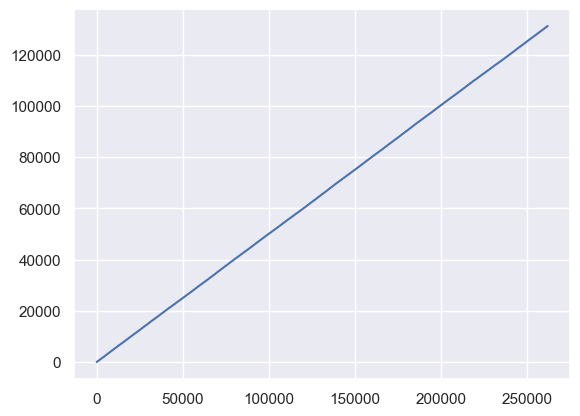

In [71]:
# Q: Data leakage?
print(set(df['id']).intersection(df_test['id']))
df['target'].cumsum().plot();
# A: No

# 2. EDA

In [72]:
# Explore numerical features
numerical_features = df.select_dtypes(include=[np.number])
print(numerical_features.shape)
summary_stats = numerical_features.describe().T

# Add number of unique values
summary_stats['n_unique'] = numerical_features.nunique()

html_numerical = create_scrollable_table(summary_stats, 'numerical_features', 'Summary statistics for numerical features')
display(HTML(html_numerical))

(262144, 257)


,count,mean,std,min,25%,50%,75%,max,n_unique
muggy-smalt-axolotl-pembus,262144.0,0.005924,1.706660,-15.588429,-0.765405,0.002148,0.769228,15.797000,254322
dorky-peach-sheepdog-ordinal,262144.0,0.000936,1.720943,-15.644144,-0.770224,0.003543,0.773400,18.577178,254588
slimy-seashell-cassowary-goose,262144.0,-0.012530,1.698693,-15.235982,-0.777421,-0.005771,0.764092,17.205310,254356
snazzy-harlequin-chicken-distraction,262144.0,-0.005688,1.874875,-15.672966,-0.802502,-0.003505,0.798460,16.585173,254576
frumpy-smalt-mau-ordinal,262144.0,0.001607,1.726869,-16.800626,-0.770838,0.000865,0.769954,16.815798,254330
stealthy-beige-pinscher-golden,262144.0,0.007878,1.734646,-14.789422,-0.771608,0.002830,0.776606,17.378922,254270
chummy-cream-tarantula-entropy,262144.0,-0.003500,1.720431,-15.591329,-0.770634,0.001257,0.769794,15.202100,254324
hazy-emerald-cuttlefish-unsorted,262144.0,-0.005927,1.693276,-15.696478,-0.764398,-0.003657,0.752836,16.645394,254224
nerdy-indigo-wolfhound-sorted,262144.0,0.002664,1.872248,-17.011807,-0.795475,0.004936,0.800376,19.396192,254752
leaky-amaranth-lizard-sorted,262144.0,0.020485,1.645070,-14.693510,-0.756594,0.004372,0.764807,17.131375,254205


In [73]:
# Explore categorical features
categorical_features = df.select_dtypes(include=[object])
print("Categorical data in training set: ", categorical_features.shape)

categorical_features_test = df_test.select_dtypes(include=[object])
print("Categorical data in test set: ", categorical_features_test.shape)

cat_summary_stats = categorical_features.describe().T
cat_summary_stats_test = categorical_features_test.describe().T

html_categorical = create_scrollable_table(cat_summary_stats, 'categorical_features', 'Summary statistics for categorical features')
html_categorical_test = create_scrollable_table(cat_summary_stats_test, 'categorical_features_test', 'Summary statistics for TEST categorical features')


display(HTML(html_categorical + html_categorical_test))

Categorical data in training set:  (262144, 1)
Categorical data in test set:  (131072, 1)


,count,unique,top,freq
id,262144,262144,707b395ecdcbb4dc2eabea00e4d1b179,1
,count,unique,top,freq
id,131072,131072,ba88c155ba898fc8b5099893036ef205,1


## Observation 1. wheezy-copper-turtle-magic
1. wheezy-copper-turtle-magic (float64 dtype) has only 512 unique entries. --> change to categorical? Additional study on interaction needed

<Figure size 640x480 with 0 Axes>

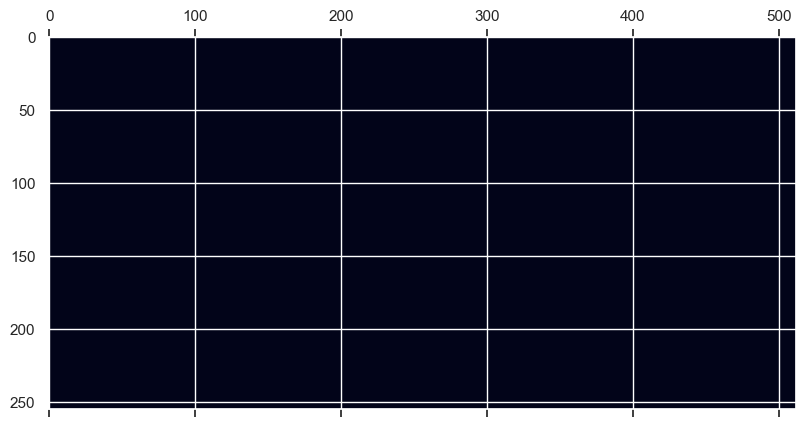

In [74]:
train_columns = [c for c in df.columns if c not in ["id", "target", "wheezy-copper-turtle-magic"]] 
interactions = np.zeros((512,255)) # num_unique X features
oof = np.zeros(len(df))
oof_test = np.zeros(len(df_test))

# Separate dataset into 512 categories (of wheezy-copper-turtle-magic values)
for i in range(512):
    train2 = df[df['wheezy-copper-turtle-magic'] == i]
    test2 = df_test[df_test['wheezy-copper-turtle-magic'] == i]
    idx1 = train2.index; idx2 = test2.index
    train2.reset_index(drop=True, inplace=True)
    test2.reset_index(drop=True, inplace=True)
    


plt.figure()
plt.matshow(interactions.transpose())

In [75]:
train_columns = [c for c in df.columns if c not in ["id", "target", "wheezy-copper-turtle-magic"]] 
# df[train_columns].nunique()
describe_train = df[train_columns].describe().T.drop("count", axis=1)
cmap = sns.diverging_palette(5,250,as_cmap=True)
styler = describe_train.style.background_gradient(cmap=cmap, axis=0).format("{:.2f}")

styled_html = styler.to_html()

def create_scrollable_table_from_html(html, table_id, title):
    return f"""
    <h3>{title}</h3>
    <div id="{table_id}" style="max-height:400px; overflow:auto; border:1px solid #ccc;">
        {html}
    </div>
    """

html_train = create_scrollable_table_from_html(
    styled_html,                       # if your function can take raw html
    'train_features',
    'Summary statistics for training features'
)

display(HTML(html_train))


,mean,std,min,25%,50%,75%,max
muggy-smalt-axolotl-pembus,0.01,1.71,-15.59,-0.77,0.00,0.77,15.80
dorky-peach-sheepdog-ordinal,0.00,1.72,-15.64,-0.77,0.00,0.77,18.58
slimy-seashell-cassowary-goose,-0.01,1.70,-15.24,-0.78,-0.01,0.76,17.21
snazzy-harlequin-chicken-distraction,-0.01,1.87,-15.67,-0.80,-0.00,0.80,16.59
frumpy-smalt-mau-ordinal,0.00,1.73,-16.80,-0.77,0.00,0.77,16.82
stealthy-beige-pinscher-golden,0.01,1.73,-14.79,-0.77,0.00,0.78,17.38
chummy-cream-tarantula-entropy,-0.00,1.72,-15.59,-0.77,0.00,0.77,15.20
hazy-emerald-cuttlefish-unsorted,-0.01,1.69,-15.70,-0.76,-0.00,0.75,16.65
nerdy-indigo-wolfhound-sorted,0.00,1.87,-17.01,-0.80,0.00,0.80,19.40
leaky-amaranth-lizard-sorted,0.02,1.65,-14.69,-0.76,0.00,0.76,17.13


['muggy-smalt-axolotl-pembus', 'nerdy-violet-rat-pembus', 'cranky-ultramarine-swan-pembus', 'silly-tan-tapir-pembus', 'pasty-aquamarine-numbat-pembus', 'skinny-cyan-macaque-pembus']


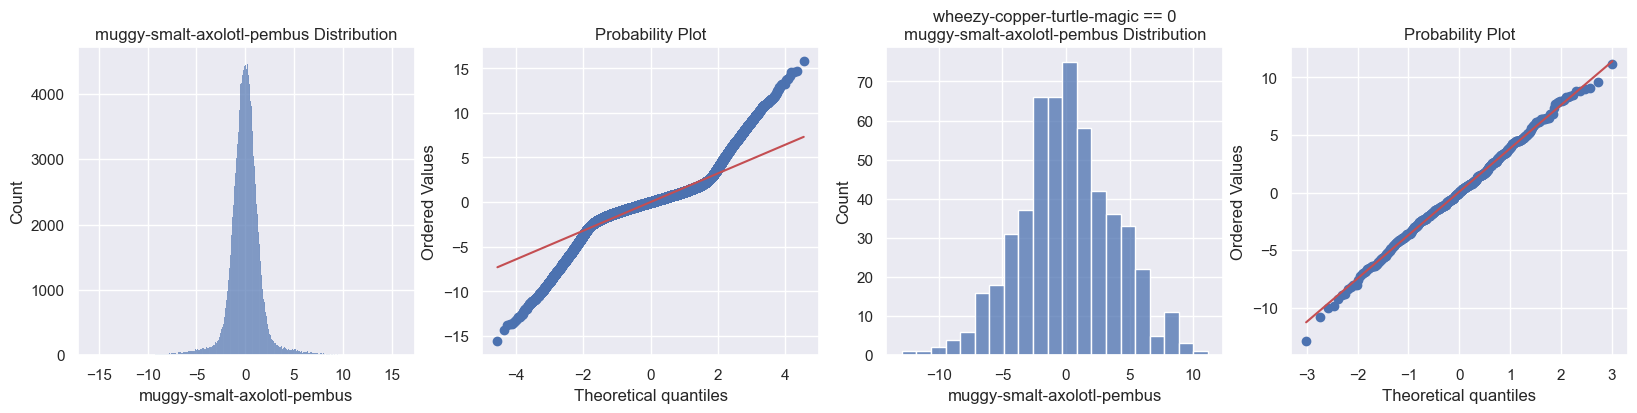

In [76]:
# choose
print([c for c in df.columns if c.find('pembus')!=-1])

from scipy.stats import probplot

f,a = plt.subplots(1,4, figsize=(20,4))
sns.histplot(df['muggy-smalt-axolotl-pembus'], ax=a[0])
a[0].set_title('muggy-smalt-axolotl-pembus Distribution')
probplot(df['muggy-smalt-axolotl-pembus'], plot=a[1])


sns.histplot(df.loc[df['wheezy-copper-turtle-magic']==0, 'muggy-smalt-axolotl-pembus'], ax=a[2])
a[2].set_title('wheezy-copper-turtle-magic == 0\nmuggy-smalt-axolotl-pembus Distribution')
probplot(df.loc[df['wheezy-copper-turtle-magic']==0, 'muggy-smalt-axolotl-pembus'], plot=a[3])
plt.show()


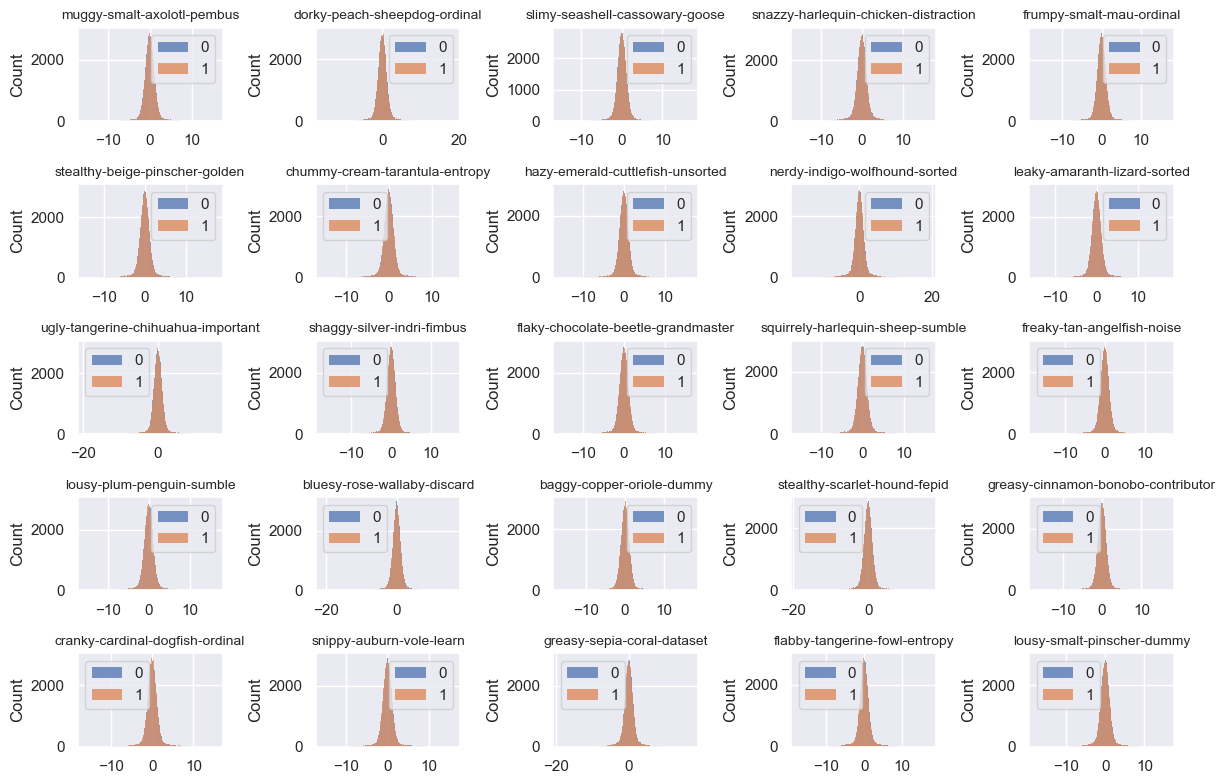

In [77]:
train_columns = [c for c in df.columns if c not in ["id", "target"]] 
temp = df
target_0_df = temp.loc[temp['target']==0]
target_1_df = temp.loc[temp['target']==1]
f,a = plt.subplots(5,5, figsize=(12,8))

for idx, name in enumerate(train_columns[:25]): # sample 25 cols
    row = idx//5
    col = idx%5
    ax = a[row][col]
    sns.histplot(target_0_df[name], ax=ax)
    sns.histplot(target_1_df[name], ax=ax)    
    std = target_0_df[name].std()
    ax.set_title(f'{name}',fontsize=10)
    ax.set_xlabel('')
    ax.legend(['0','1'])

plt.tight_layout()
plt.show()


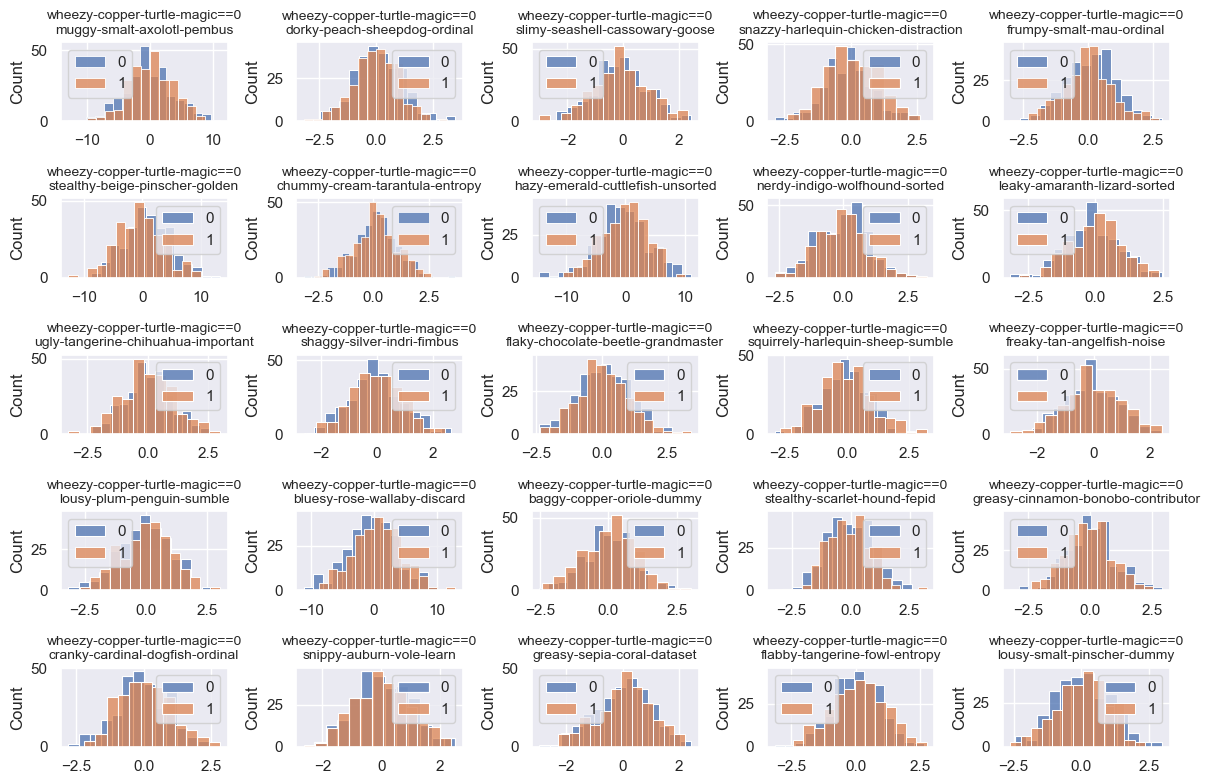

In [78]:
train_columns = [c for c in df.columns if c not in ["id", "target"]] 
temp = df.loc[df["wheezy-copper-turtle-magic"]==0]
target_0_df = temp.loc[temp['target']==0]
target_1_df = temp.loc[temp['target']==1]
f,a = plt.subplots(5,5, figsize=(12,8))

for idx, name in enumerate(train_columns[:25]): # sample 25 cols
    row = idx//5
    col = idx%5
    ax = a[row][col]
    sns.histplot(target_0_df[name], ax=ax)
    sns.histplot(target_1_df[name], ax=ax)    
    std = target_0_df[name].std()
    ax.set_title(f'wheezy-copper-turtle-magic==0\n{name}',fontsize=10)
    ax.set_xlabel('')
    ax.legend(['0','1'])

plt.tight_layout()
plt.show()


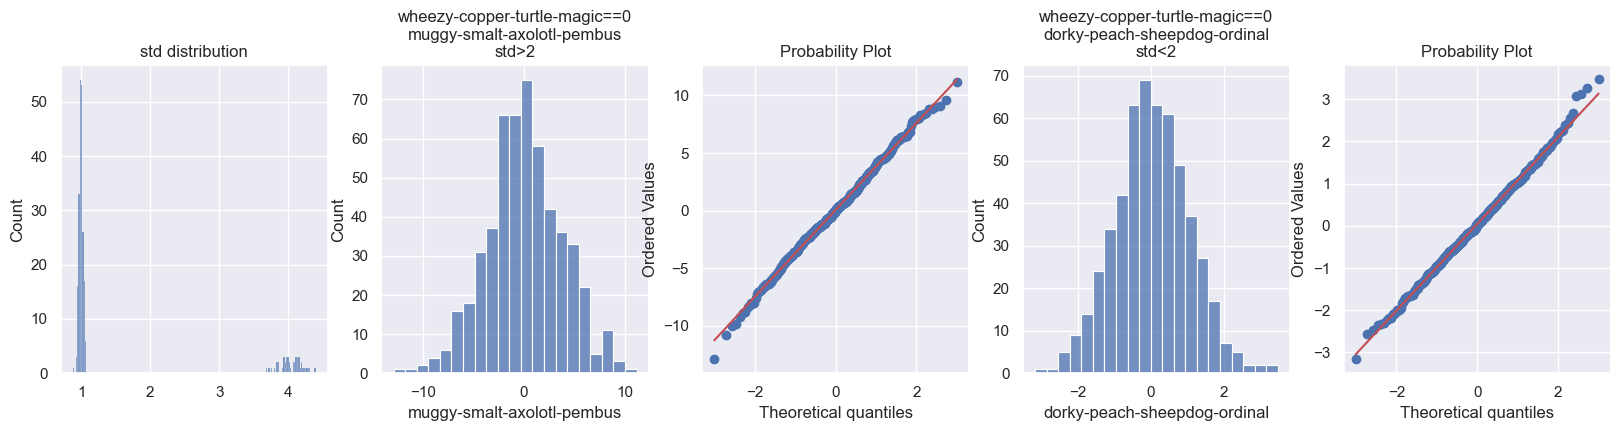

In [79]:


f, a = plt.subplots(1,5,figsize=(20,4))
train_columns = [c for c in df.columns if c not in ['id', 'target', 'wheezy-copper-turtle-magic']]
temp = df.loc[df['wheezy-copper-turtle-magic']==0,train_columns].std()
sns.histplot(temp,ax=a[0])
a[0].set_title('std distribution')

large_std = list(temp.index.values[temp>2])
small_std = list(temp.index.values[temp<2])

# example distribution with feature with large stdev
sns.histplot(df.loc[df['wheezy-copper-turtle-magic']==0,large_std[0]],ax=a[1])
a[1].set_title(f'wheezy-copper-turtle-magic==0\n{large_std[0]}\nstd>2')
probplot(df.loc[df['wheezy-copper-turtle-magic']==0,large_std[0]], plot=a[2])

# example distribution with feature with small stdev
sns.histplot(df.loc[df['wheezy-copper-turtle-magic']==0,small_std[0]],ax=a[3])
a[3].set_title(f'wheezy-copper-turtle-magic==0\n{small_std[0]}\nstd<2')
probplot(df.loc[df['wheezy-copper-turtle-magic']==0,small_std[0]], plot=a[4]);


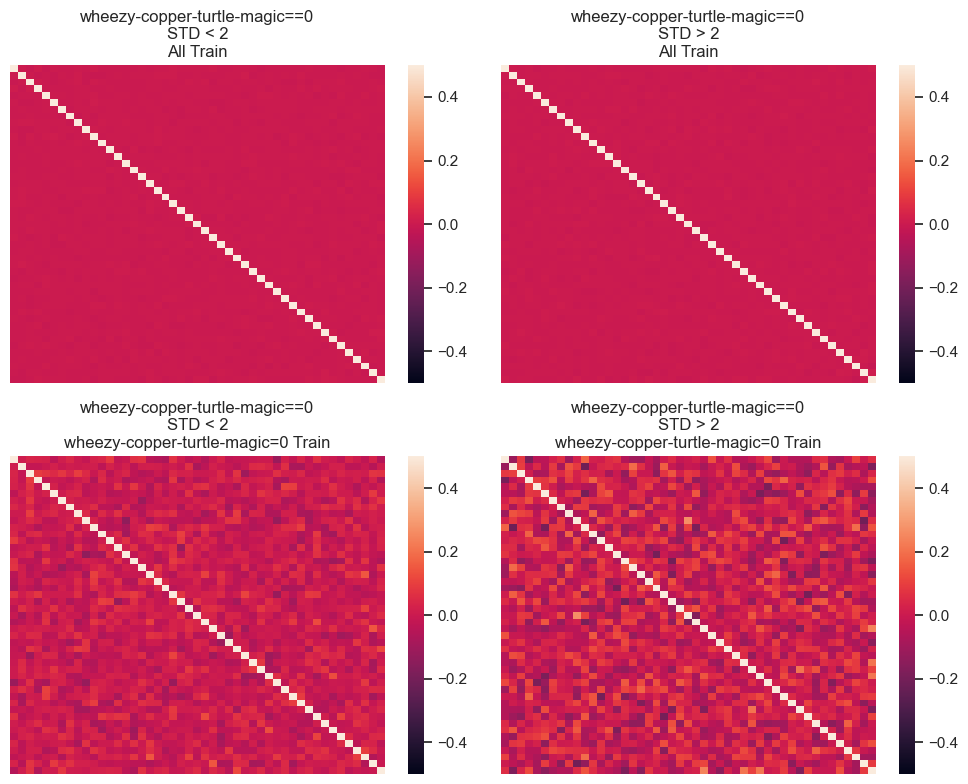

In [ ]:
f, a = plt.subplots(2,2,figsize=(10,8))
vmin = -0.5
vmax = 0.5

sns.heatmap(df[small_std[:len(large_std)]+['target']].corr(), vmin=vmin, vmax=vmax,xticklabels=False, yticklabels=False,ax=a[0][0])
a[0][0].set_title('wheezy-copper-turtle-magic==0\nSTD < 2\nAll Train')

sns.heatmap(df[large_std+['target']].corr(), vmin=vmin, vmax=vmax,xticklabels=False, yticklabels=False,ax=a[0][1])
a[0][1].set_title('wheezy-copper-turtle-magic==0\nSTD > 2\nAll Train')

sns.heatmap(df.loc[df['wheezy-copper-turtle-magic']==0,small_std[:len(large_std)]+['target']].corr(), vmin=vmin, vmax=vmax,xticklabels=False, yticklabels=False,ax=a[1][0])
a[1][0].set_title('wheezy-copper-turtle-magic==0\nSTD < 2\nwheezy-copper-turtle-magic=0 Train')

sns.heatmap(df.loc[df['wheezy-copper-turtle-magic']==0,large_std+['target']].corr(), vmin=vmin, vmax=vmax,xticklabels=False, yticklabels=False,ax=a[1][1])
a[1][1].set_title('wheezy-copper-turtle-magic==0\nSTD > 2\nwheezy-copper-turtle-magic=0 Train')

plt.tight_layout()
plt.show()

## Observation 2

- Tested few different values of "wheezy-copper-turtle-magic". (Above plot shows distribution for wheezy-copper-turtle-magic==0). Will refer to this value as "magic" value.
- Depending on wheezy-copper-turtle-magic, numerical feature values are distributed either between -10~10 or -2~2 (two patterns).
- Close look at stdev distribution: Data separates into two groups (stdev~1 and stdev~3-4) at specific "magic" value (separation at stdev=2)
- Can see more details on feature's interaction when isolating data by "magic" value and large_std group



In [86]:
variance_over_2std = {}
for i in range(512):
    x_train = df[df['wheezy-copper-turtle-magic'] == i]
    x_test = df_test[df_test['wheezy-copper-turtle-magic'] == i]

    train_std = x_train[train_columns].std()
    cols = list(train_std.index.values[np.where(train_std >2)])
    variance_over_2std[i] = cols.copy()

intersect_count = np.zeros((512,512))
for k, v in variance_over_2std.items():
    for k1, v1 in variance_over_2std.items():
        intersect_count[k,k1] = len(set(v).intersection(set(v1)))
        

<Axes: >

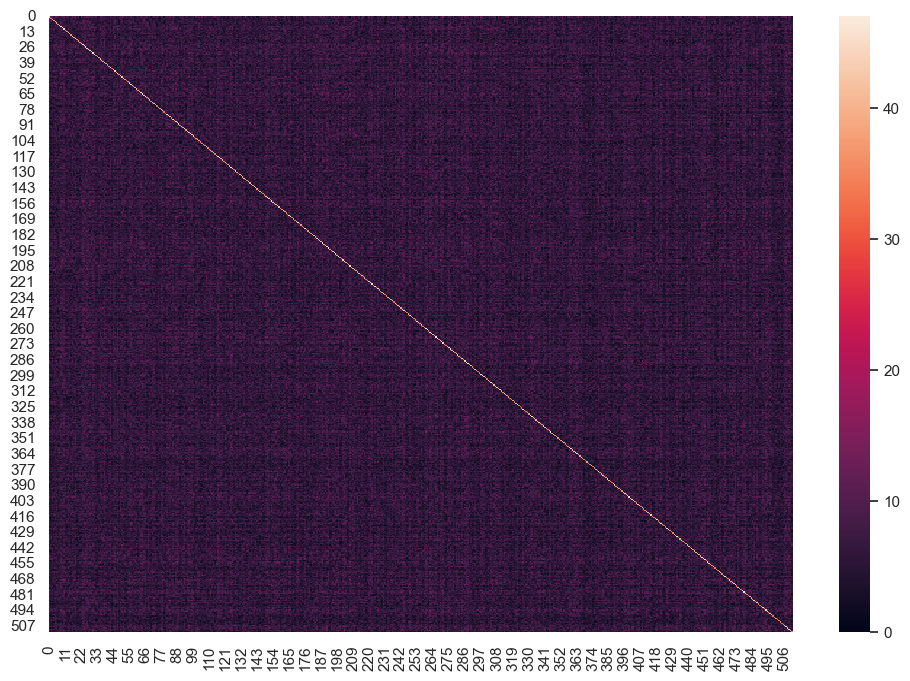

In [87]:
plt.figure(figsize=(12,8))
sns.heatmap(pd.DataFrame(intersect_count))

## Observation 3: 

We defined feature with std>2 at specific "magic" number to be "useful".
Above heatmap shows the number of "useful" feature at different "magic" number. 

There seem to be no pattern in "usefulness" of the feature when we look across different "magic" numbers.

Also, there is not enough overlap in "useful" feature at specific "magic number" also (overall appears purple, i.e. less than 15 features). 

## Conclusion:
Need to test 512 separate models for different "magic" number groups

# 3. Model: Stacking

Will use 6 models: 2 NuSVC, QuadraticDiscriminantAnalysis, svc, knn, logistic regression

Following material from https://www.kaggle.com/code/yeonmin/solution


In [100]:
import lightgbm as lgbm
from sklearn import neural_network


In [17]:
# setting params for models
svnu_params = {
    'probability':True, 
    'kernel':'poly',
    'degree':4,
    'gamma':'auto',
    'nu':0.4,'coef0':0.08, 
    'random_state':4}
svnu2_params = {
    'probability':True, 
    'kernel':'poly',
    'degree':2,
    'gamma':'auto',
    'nu':0.4,'coef0':0.08, 
    'random_state':4}
qda_params = {'reg_param':0.111}
svc_params = {
    'probability':True,
    'kernel':'poly',
    'degree':4,
    'gamma':'auto', 
    'random_state':4}
neighbor_params = {'n_neighbors':16}
lr_params = {'solver':'liblinear','penalty':'l1','C':0.05,'random_state':42}

In [88]:
# Frequency Encoding

class hist_model(object):
    
    def __init__(self, bins=50):
        self.bins = bins
        
    def fit(self, X):
        
        bin_height, bin_edge = [], []
        
        for var in X.T:
            bh, bedge = np.histogram(var, bins=self.bins)
            bin_height.append(bh)
            bin_edge.append(bedge)
        
        self.bin_height = np.array(bin_height)
        self.bin_edge = np.array(bin_edge)
        
    def predict(self, X):
        
        scores = []
        for obs in X:
            obs_score = []
            for i, var in enumerate(obs):
                bin_num = (var > self.bin_edge[i]).argmin() - 1
                obs_score.append(self.bin_height[i, bin_num])
                
            scores.append(np.mean(obs_score))

        return np.array(scores)

In [94]:
from sklearn import svm
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import neighbors
from sklearn import linear_model
from tqdm import tqdm_notebook
from sklearn.decomposition import KernelPCA
from sklearn.mixture import GaussianMixture as GMM
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score


def run_model(clf_list, train_df, test_df, random_state, gmm_init_params='kmeans'):
    MODEL_COUNT = len(clf_list)
    
    oof_train = np.zeros((len(train_df), MODEL_COUNT))
    oof_test = np.zeros((len(test_df), MODEL_COUNT))
    train_columns = [c for c in train_df.columns if c not in ['id', 'target', 'wheezy-copper-turtle-magic']]
    
    for magic in tqdm_notebook(range(512)):
        x_train = train_df[train_df['wheezy-copper-turtle-magic'] == magic]
        x_test = test_df[test_df['wheezy-copper-turtle-magic'] == magic]
        print(f'Magic: {magic}, x_train: {x_train.shape}, x_test: {x_test.shape}')
        
        train_idx_origin = x_train.index
        test_idx_origin = x_test.index
        
        train_std = x_train[train_columns].std()
        cols = list(train_std.index.values[np.where(train_std>2)])
        
        x_train = x_train.reset_index(drop=True)
        y_train = x_train.target
        
        x_train = x_train[cols].values
        x_test = x_test[cols].values
        
        all_df = np.vstack([x_train, x_test])
        
        # Kernel PCA
        all_df = KernelPCA(n_components=len(cols), kernel='cosine').fit_transform(all_df)
        
        # GMM
        # gmm = GMM(n_components=5, max_iter=1000, init_params=gmm_init_params).fit(all_df)
        gmm = GMM(n_components=5, random_state=random_state, max_iter=1000, init_params=gmm_init_params).fit(all_df)

        gmm_pred = gmm.predict_proba(all_df)
        gmm_score = gmm.score_samples(all_df).reshape(-1, 1)
        gmm_label = gmm.predict(all_df)
        
        # hist feature
        hist = hist_model()
        hist.fit(all_df)
        hist_pred = hist.predict(all_df).reshape(-1, 1)
        
        all_df = np.hstack([all_df, gmm_pred, gmm_pred, gmm_pred, gmm_pred])
        
        all_df = np.hstack([all_df, hist_pred, gmm_score, gmm_score, gmm_score])
        
        # standard scaler
        all_df = StandardScaler().fit_transform(all_df)
        
        x_train = all_df[:x_train.shape[0]]
        x_test = all_df[x_train.shape[0]:]
        
        fold = StratifiedKFold(n_splits=5)
        for trn_idx, val_idx in fold.split(x_train, gmm_label[:x_train.shape[0]]):
            for model_index, clf in enumerate(clf_list):
                clf.fit(x_train[trn_idx], y_train[trn_idx])
                oof_train[train_idx_origin[val_idx], model_index] = clf.predict_proba(x_train[val_idx])[:, 1]
                
                if x_test.shape[0] == 0:
                    continue
                    
                oof_test[test_idx_origin, model_index] += clf.predict_proba(x_test)[:, 1] / fold.n_splits
        
    for i, clf in enumerate(clf_list):
        print(clf)
        print(roc_auc_score(train_df['target'], oof_train[:, i]))
        print()
            
    oof_train_df = pd.DataFrame(oof_train)
    oof_test_df = pd.DataFrame(oof_test)
        
    return oof_train_df, oof_test_df

In [24]:
# Prep models
nusvc_model = svm.NuSVC(**svnu_params)
nusvc2_model = svm.NuSVC(**svnu2_params)
qda_model = QuadraticDiscriminantAnalysis(**qda_params)
svc_model = svm.SVC(**svc_params)
knn_model = neighbors.KNeighborsClassifier(**neighbor_params)
lr_model = linear_model.LogisticRegression(**lr_params)

model_list = [nusvc_model, nusvc2_model, qda_model, svc_model, knn_model, lr_model]

In [95]:
# Stack, Run Model
oof_train_kmeans_seed1, oof_test_kmeans_seed1 = run_model(model_list, df, df_test, 1)
oof_train_kmeans_seed2, oof_test_kmeans_seed2 = run_model(model_list, df, df_test, 2)

oof_train_random_seed1, oof_test_random_seed1 = run_model(model_list, df, df_test, 1, "random")
oof_train_random_seed2, oof_test_random_seed2 = run_model(model_list, df, df_test, 2, "random")



/var/folders/3d/m4qxblss59v1_15fy02hrkyh0000gn/T/ipykernel_5143/2101865987.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for magic in tqdm_notebook(range(512)):


  0%|          | 0/512 [00:00<?, ?it/s]

Magic: 0, x_train: (534, 258), x_test: (0, 257)


python(23070) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Magic: 1, x_train: (510, 258), x_test: (0, 257)
Magic: 2, x_train: (495, 258), x_test: (0, 257)
Magic: 3, x_train: (538, 258), x_test: (0, 257)
Magic: 4, x_train: (516, 258), x_test: (0, 257)
Magic: 5, x_train: (521, 258), x_test: (0, 257)
Magic: 6, x_train: (518, 258), x_test: (0, 257)
Magic: 7, x_train: (506, 258), x_test: (0, 257)
Magic: 8, x_train: (522, 258), x_test: (0, 257)
Magic: 9, x_train: (528, 258), x_test: (0, 257)
Magic: 10, x_train: (498, 258), x_test: (0, 257)
Magic: 11, x_train: (482, 258), x_test: (0, 257)
Magic: 12, x_train: (496, 258), x_test: (0, 257)
Magic: 13, x_train: (485, 258), x_test: (0, 257)
Magic: 14, x_train: (486, 258), x_test: (0, 257)
Magic: 15, x_train: (516, 258), x_test: (0, 257)
Magic: 16, x_train: (517, 258), x_test: (0, 257)
Magic: 17, x_train: (511, 258), x_test: (0, 257)
Magic: 18, x_train: (518, 258), x_test: (0, 257)
Magic: 19, x_train: (526, 258), x_test: (0, 257)
Magic: 20, x_train: (512, 258), x_test: (0, 257)
Magic: 21, x_train: (532, 258

/var/folders/3d/m4qxblss59v1_15fy02hrkyh0000gn/T/ipykernel_5143/2101865987.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for magic in tqdm_notebook(range(512)):


  0%|          | 0/512 [00:00<?, ?it/s]

Magic: 0, x_train: (534, 258), x_test: (0, 257)
Magic: 1, x_train: (510, 258), x_test: (0, 257)
Magic: 2, x_train: (495, 258), x_test: (0, 257)
Magic: 3, x_train: (538, 258), x_test: (0, 257)
Magic: 4, x_train: (516, 258), x_test: (0, 257)
Magic: 5, x_train: (521, 258), x_test: (0, 257)
Magic: 6, x_train: (518, 258), x_test: (0, 257)
Magic: 7, x_train: (506, 258), x_test: (0, 257)
Magic: 8, x_train: (522, 258), x_test: (0, 257)
Magic: 9, x_train: (528, 258), x_test: (0, 257)
Magic: 10, x_train: (498, 258), x_test: (0, 257)
Magic: 11, x_train: (482, 258), x_test: (0, 257)
Magic: 12, x_train: (496, 258), x_test: (0, 257)
Magic: 13, x_train: (485, 258), x_test: (0, 257)
Magic: 14, x_train: (486, 258), x_test: (0, 257)
Magic: 15, x_train: (516, 258), x_test: (0, 257)
Magic: 16, x_train: (517, 258), x_test: (0, 257)
Magic: 17, x_train: (511, 258), x_test: (0, 257)
Magic: 18, x_train: (518, 258), x_test: (0, 257)
Magic: 19, x_train: (526, 258), x_test: (0, 257)
Magic: 20, x_train: (512, 258)

/var/folders/3d/m4qxblss59v1_15fy02hrkyh0000gn/T/ipykernel_5143/2101865987.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for magic in tqdm_notebook(range(512)):


  0%|          | 0/512 [00:00<?, ?it/s]

Magic: 0, x_train: (534, 258), x_test: (0, 257)
Magic: 1, x_train: (510, 258), x_test: (0, 257)
Magic: 2, x_train: (495, 258), x_test: (0, 257)
Magic: 3, x_train: (538, 258), x_test: (0, 257)
Magic: 4, x_train: (516, 258), x_test: (0, 257)
Magic: 5, x_train: (521, 258), x_test: (0, 257)
Magic: 6, x_train: (518, 258), x_test: (0, 257)
Magic: 7, x_train: (506, 258), x_test: (0, 257)
Magic: 8, x_train: (522, 258), x_test: (0, 257)
Magic: 9, x_train: (528, 258), x_test: (0, 257)
Magic: 10, x_train: (498, 258), x_test: (0, 257)
Magic: 11, x_train: (482, 258), x_test: (0, 257)
Magic: 12, x_train: (496, 258), x_test: (0, 257)
Magic: 13, x_train: (485, 258), x_test: (0, 257)
Magic: 14, x_train: (486, 258), x_test: (0, 257)
Magic: 15, x_train: (516, 258), x_test: (0, 257)
Magic: 16, x_train: (517, 258), x_test: (0, 257)
Magic: 17, x_train: (511, 258), x_test: (0, 257)
Magic: 18, x_train: (518, 258), x_test: (0, 257)
Magic: 19, x_train: (526, 258), x_test: (0, 257)
Magic: 20, x_train: (512, 258)

/var/folders/3d/m4qxblss59v1_15fy02hrkyh0000gn/T/ipykernel_5143/2101865987.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for magic in tqdm_notebook(range(512)):


  0%|          | 0/512 [00:00<?, ?it/s]

Magic: 0, x_train: (534, 258), x_test: (0, 257)
Magic: 1, x_train: (510, 258), x_test: (0, 257)
Magic: 2, x_train: (495, 258), x_test: (0, 257)
Magic: 3, x_train: (538, 258), x_test: (0, 257)
Magic: 4, x_train: (516, 258), x_test: (0, 257)
Magic: 5, x_train: (521, 258), x_test: (0, 257)
Magic: 6, x_train: (518, 258), x_test: (0, 257)
Magic: 7, x_train: (506, 258), x_test: (0, 257)
Magic: 8, x_train: (522, 258), x_test: (0, 257)
Magic: 9, x_train: (528, 258), x_test: (0, 257)
Magic: 10, x_train: (498, 258), x_test: (0, 257)
Magic: 11, x_train: (482, 258), x_test: (0, 257)
Magic: 12, x_train: (496, 258), x_test: (0, 257)
Magic: 13, x_train: (485, 258), x_test: (0, 257)
Magic: 14, x_train: (486, 258), x_test: (0, 257)
Magic: 15, x_train: (516, 258), x_test: (0, 257)
Magic: 16, x_train: (517, 258), x_test: (0, 257)
Magic: 17, x_train: (511, 258), x_test: (0, 257)
Magic: 18, x_train: (518, 258), x_test: (0, 257)
Magic: 19, x_train: (526, 258), x_test: (0, 257)
Magic: 20, x_train: (512, 258)

In [97]:
train_second = (oof_train_kmeans_seed1 + oof_train_kmeans_seed2 + oof_train_random_seed1 + oof_train_random_seed2)/4
test_second = (oof_test_kmeans_seed1 + oof_test_kmeans_seed2 + oof_test_random_seed1 + oof_test_random_seed2)/4
print('Ensemble', roc_auc_score(df['target'], train_second.mean(1)))

Ensemble 0.96646707989694


## Final Training

In [102]:
lgbm_meta_param = {
        #'bagging_freq': 5,
        #'bagging_fraction': 0.8,
        'min_child_weight':6.790,
        "subsample_for_bin":50000,
        'bagging_seed': 0,
        'boost_from_average':'true',
        'boost': 'gbdt',
        'feature_fraction': 0.450,
        'bagging_fraction': 0.343,
        'learning_rate': 0.025,
        'max_depth': 10,
        'metric':'auc',
        'min_data_in_leaf': 78,
        'min_sum_hessian_in_leaf': 8, 
        'num_leaves': 18,
        'num_threads': 8,
        'tree_learner': 'serial',
        'objective': 'binary', 
        'verbosity': 1,
        'lambda_l1': 7.961,
        'lambda_l2': 7.781,
        'verbose': -1,   # supress info logs
        'verbotisy': -1,    # supress warnings
        #'reg_lambda': 0.3,
    }

mlp16_params = {'activation':'relu','solver':'lbfgs','tol':1e-06, 'hidden_layer_sizes':(16, ), 'random_state':42}


In [105]:
SEED_NUMBER = 4
NFOLD = 5

y_train = df['target']
oof_lgbm_meta_train = np.zeros((len(df), SEED_NUMBER))
oof_lgbm_meta_test = np.zeros((len(df_test), SEED_NUMBER))
oof_mlp_meta_train = np.zeros((len(df), SEED_NUMBER))
oof_mlp_meta_test = np.zeros((len(df_test), SEED_NUMBER))

for seed in range(SEED_NUMBER):
    print(f'SEED Ensemble: {seed}')
    
    mlp16_params['random_state'] = seed
    lgbm_meta_param['seed'] = seed
    
    folds = StratifiedKFold(n_splits=NFOLD, shuffle=True, random_state=seed)
    for fold_idx, (trn_idx, val_idx) in enumerate(folds.split(train_second, y_train)):
        print(f'{fold_idx} Fold Start')
        
        trn_x, trn_y = train_second.iloc[trn_idx], y_train.iloc[trn_idx]
        val_x, val_y = train_second.iloc[val_idx], y_train.iloc[val_idx]
        
        mlp_meta_model = neural_network.MLPClassifier(**mlp16_params)
        mlp_meta_model.fit(trn_x, trn_y)
        
        oof_mlp_meta_train[val_idx, seed] = mlp_meta_model.predict_proba(val_x)[:, 1]
        oof_mlp_meta_test[:, seed] += mlp_meta_model.predict_proba(test_second)[:, 1]/NFOLD
        print(f'MLP META SCORE: {roc_auc_score(val_y, oof_mlp_meta_train[val_idx, seed])}')
        
        dtrain = lgbm.Dataset(trn_x, label=trn_y)
        dcross = lgbm.Dataset(val_x, label=val_y)
        
        lgbm_meta_model = lgbm.train(
            lgbm_meta_param, 
            train_set=dtrain, 
            valid_sets=[dtrain, dcross], 
            callbacks=[
                lgbm.log_evaluation(period=0),
                lgbm.early_stopping(stopping_rounds=100),
                ], 
            )
        
        oof_lgbm_meta_train[val_idx, seed] = lgbm_meta_model.predict(val_x)
        oof_lgbm_meta_test[:, seed] += lgbm_meta_model.predict(test_second)/NFOLD
        
        print(f'LGBM META SCORE: {roc_auc_score(val_y, oof_lgbm_meta_train[val_idx, seed])}')

SEED Ensemble: 0
0 Fold Start


/opt/anaconda3/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLP META SCORE: 0.9685779455275165
[LightGBM] [Warning] Unknown parameter: verbotisy
[LightGBM] [Warning] verbosity is set=1, verbose=-1 will be ignored. Current value: verbosity=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=6.79 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] Unknown parameter: verbotisy
[LightGBM] [Warning] verbosity is set=1, verbose=-1 will be ignored. Current value: verbosity=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=6.79 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Info] Number of positive: 104905, number of negative: 104810
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003538 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1340
[LightGBM] [Info] Number of data points in the train set: 209715, numb

/opt/anaconda3/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLP META SCORE: 0.9684375278658008
[LightGBM] [Warning] Unknown parameter: verbotisy
[LightGBM] [Warning] verbosity is set=1, verbose=-1 will be ignored. Current value: verbosity=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=6.79 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] Unknown parameter: verbotisy
[LightGBM] [Warning] verbosity is set=1, verbose=-1 will be ignored. Current value: verbosity=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=6.79 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Info] Number of positive: 104905, number of negative: 104810
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1340
[LightGBM] [Info] Number of data points in the train set: 209715, numb

/opt/anaconda3/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLP META SCORE: 0.9692889977492108
[LightGBM] [Warning] Unknown parameter: verbotisy
[LightGBM] [Warning] verbosity is set=1, verbose=-1 will be ignored. Current value: verbosity=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=6.79 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] Unknown parameter: verbotisy
[LightGBM] [Warning] verbosity is set=1, verbose=-1 will be ignored. Current value: verbosity=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=6.79 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Info] Number of positive: 104905, number of negative: 104810
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1340
[LightGBM] [Info] Number of data points in the train set: 209715, number of used features: 6
[LightGBM] [Warning] Unknown parameter: v

/opt/anaconda3/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLP META SCORE: 0.9691785251747158
[LightGBM] [Warning] Unknown parameter: verbotisy
[LightGBM] [Warning] verbosity is set=1, verbose=-1 will be ignored. Current value: verbosity=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=6.79 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] Unknown parameter: verbotisy
[LightGBM] [Warning] verbosity is set=1, verbose=-1 will be ignored. Current value: verbosity=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=6.79 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Info] Number of positive: 104904, number of negative: 104811
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1340
[LightGBM] [Info] Number of data points in the train set: 209715, numb

/opt/anaconda3/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLP META SCORE: 0.968177224292063
[LightGBM] [Warning] Unknown parameter: verbotisy
[LightGBM] [Warning] verbosity is set=1, verbose=-1 will be ignored. Current value: verbosity=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=6.79 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] Unknown parameter: verbotisy
[LightGBM] [Warning] verbosity is set=1, verbose=-1 will be ignored. Current value: verbosity=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=6.79 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Info] Number of positive: 104905, number of negative: 104811
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1340
[LightGBM] [Info] Number of data points in the train set: 209716, number of used features: 6
[LightGBM] [Warning] Unknown parameter: ve

/opt/anaconda3/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLP META SCORE: 0.9689322238209128
[LightGBM] [Warning] Unknown parameter: verbotisy
[LightGBM] [Warning] verbosity is set=1, verbose=-1 will be ignored. Current value: verbosity=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=6.79 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] Unknown parameter: verbotisy
[LightGBM] [Warning] verbosity is set=1, verbose=-1 will be ignored. Current value: verbosity=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=6.79 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Info] Number of positive: 104905, number of negative: 104810
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1340
[LightGBM] [Info] Number of data points in the train set: 209715, numb

/opt/anaconda3/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLP META SCORE: 0.968639084944657
[LightGBM] [Warning] Unknown parameter: verbotisy
[LightGBM] [Warning] verbosity is set=1, verbose=-1 will be ignored. Current value: verbosity=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=6.79 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] Unknown parameter: verbotisy
[LightGBM] [Warning] verbosity is set=1, verbose=-1 will be ignored. Current value: verbosity=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=6.79 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Info] Number of positive: 104905, number of negative: 104810
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1340
[LightGBM] [Info] Number of data points in the train set: 209715, number of used features: 6
[LightGBM] [Warning] Unknown parameter: ve

/opt/anaconda3/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLP META SCORE: 0.9678750699661797
[LightGBM] [Warning] Unknown parameter: verbotisy
[LightGBM] [Warning] verbosity is set=1, verbose=-1 will be ignored. Current value: verbosity=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=6.79 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] Unknown parameter: verbotisy
[LightGBM] [Warning] verbosity is set=1, verbose=-1 will be ignored. Current value: verbosity=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=6.79 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Info] Number of positive: 104905, number of negative: 104810
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1340
[LightGBM] [Info] Number of data points in the train set: 209715, numb

/opt/anaconda3/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLP META SCORE: 0.9693670263789085
[LightGBM] [Warning] Unknown parameter: verbotisy
[LightGBM] [Warning] verbosity is set=1, verbose=-1 will be ignored. Current value: verbosity=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=6.79 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] Unknown parameter: verbotisy
[LightGBM] [Warning] verbosity is set=1, verbose=-1 will be ignored. Current value: verbosity=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=6.79 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Info] Number of positive: 104904, number of negative: 104811
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001012 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1340
[LightGBM] [Info] Number of data points in the train set: 209715, numb

/opt/anaconda3/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLP META SCORE: 0.9685814845531941
[LightGBM] [Warning] Unknown parameter: verbotisy
[LightGBM] [Warning] verbosity is set=1, verbose=-1 will be ignored. Current value: verbosity=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=6.79 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] Unknown parameter: verbotisy
[LightGBM] [Warning] verbosity is set=1, verbose=-1 will be ignored. Current value: verbosity=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=6.79 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Info] Number of positive: 104905, number of negative: 104811
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1340
[LightGBM] [Info] Number of data points in the train set: 209716, numb

/opt/anaconda3/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLP META SCORE: 0.9683317813394606
[LightGBM] [Warning] Unknown parameter: verbotisy
[LightGBM] [Warning] verbosity is set=1, verbose=-1 will be ignored. Current value: verbosity=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=6.79 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] Unknown parameter: verbotisy
[LightGBM] [Warning] verbosity is set=1, verbose=-1 will be ignored. Current value: verbosity=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=6.79 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Info] Number of positive: 104905, number of negative: 104810
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1340
[LightGBM] [Info] Number of data points in the train set: 209715, number of used features: 6
[LightGBM] [Warning] Unknown parameter: v

/opt/anaconda3/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLP META SCORE: 0.9682496334785439
[LightGBM] [Warning] Unknown parameter: verbotisy
[LightGBM] [Warning] verbosity is set=1, verbose=-1 will be ignored. Current value: verbosity=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=6.79 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] Unknown parameter: verbotisy
[LightGBM] [Warning] verbosity is set=1, verbose=-1 will be ignored. Current value: verbosity=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=6.79 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Info] Number of positive: 104905, number of negative: 104810
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1340
[LightGBM] [Info] Number of data points in the train set: 209715, number of used features: 6
[LightGBM] [Warning] Unknown parameter: v

/opt/anaconda3/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLP META SCORE: 0.9699092859850595
[LightGBM] [Warning] Unknown parameter: verbotisy
[LightGBM] [Warning] verbosity is set=1, verbose=-1 will be ignored. Current value: verbosity=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=6.79 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] Unknown parameter: verbotisy
[LightGBM] [Warning] verbosity is set=1, verbose=-1 will be ignored. Current value: verbosity=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=6.79 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Info] Number of positive: 104905, number of negative: 104810
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1340
[LightGBM] [Info] Number of data points in the train set: 209715, number of used features: 6
[LightGBM] [Warning] Unknown parameter: v

/opt/anaconda3/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLP META SCORE: 0.9682342496539587
[LightGBM] [Warning] Unknown parameter: verbotisy
[LightGBM] [Warning] verbosity is set=1, verbose=-1 will be ignored. Current value: verbosity=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=6.79 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] Unknown parameter: verbotisy
[LightGBM] [Warning] verbosity is set=1, verbose=-1 will be ignored. Current value: verbosity=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=6.79 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Info] Number of positive: 104904, number of negative: 104811
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1340
[LightGBM] [Info] Number of data points in the train set: 209715, numb

/opt/anaconda3/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLP META SCORE: 0.9688388096114023
[LightGBM] [Warning] Unknown parameter: verbotisy
[LightGBM] [Warning] verbosity is set=1, verbose=-1 will be ignored. Current value: verbosity=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=6.79 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] Unknown parameter: verbotisy
[LightGBM] [Warning] verbosity is set=1, verbose=-1 will be ignored. Current value: verbosity=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=6.79 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Info] Number of positive: 104905, number of negative: 104811
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1340
[LightGBM] [Info] Number of data points in the train set: 209716, number of used features: 6
[LightGBM] [Warning] Unknown parameter: v

/opt/anaconda3/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLP META SCORE: 0.9681940513964992
[LightGBM] [Warning] Unknown parameter: verbotisy
[LightGBM] [Warning] verbosity is set=1, verbose=-1 will be ignored. Current value: verbosity=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=6.79 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] Unknown parameter: verbotisy
[LightGBM] [Warning] verbosity is set=1, verbose=-1 will be ignored. Current value: verbosity=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=6.79 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Info] Number of positive: 104905, number of negative: 104810
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1340
[LightGBM] [Info] Number of data points in the train set: 209715, numb

/opt/anaconda3/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLP META SCORE: 0.9693405693532443
[LightGBM] [Warning] Unknown parameter: verbotisy
[LightGBM] [Warning] verbosity is set=1, verbose=-1 will be ignored. Current value: verbosity=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=6.79 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] Unknown parameter: verbotisy
[LightGBM] [Warning] verbosity is set=1, verbose=-1 will be ignored. Current value: verbosity=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=6.79 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Info] Number of positive: 104905, number of negative: 104810
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1340
[LightGBM] [Info] Number of data points in the train set: 209715, number of used features: 6
[LightGBM] [Warning] Unknown parameter: v

/opt/anaconda3/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLP META SCORE: 0.969607039132798
[LightGBM] [Warning] Unknown parameter: verbotisy
[LightGBM] [Warning] verbosity is set=1, verbose=-1 will be ignored. Current value: verbosity=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=6.79 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] Unknown parameter: verbotisy
[LightGBM] [Warning] verbosity is set=1, verbose=-1 will be ignored. Current value: verbosity=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=6.79 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Info] Number of positive: 104905, number of negative: 104810
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000905 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1340
[LightGBM] [Info] Number of data points in the train set: 209715, numbe

/opt/anaconda3/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLP META SCORE: 0.9681488785648082
[LightGBM] [Warning] Unknown parameter: verbotisy
[LightGBM] [Warning] verbosity is set=1, verbose=-1 will be ignored. Current value: verbosity=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=6.79 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] Unknown parameter: verbotisy
[LightGBM] [Warning] verbosity is set=1, verbose=-1 will be ignored. Current value: verbosity=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=6.79 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Info] Number of positive: 104904, number of negative: 104811
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1340
[LightGBM] [Info] Number of data points in the train set: 209715, numb

/opt/anaconda3/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLP META SCORE: 0.9687173832444903
[LightGBM] [Warning] Unknown parameter: verbotisy
[LightGBM] [Warning] verbosity is set=1, verbose=-1 will be ignored. Current value: verbosity=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=6.79 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] Unknown parameter: verbotisy
[LightGBM] [Warning] verbosity is set=1, verbose=-1 will be ignored. Current value: verbosity=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=6.79 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Info] Number of positive: 104905, number of negative: 104811
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1340
[LightGBM] [Info] Number of data points in the train set: 209716, number of used features: 6
[LightGBM] [Warning] Unknown parameter: v

In [106]:
oof_lgbm_meta_train_df = pd.DataFrame(oof_lgbm_meta_train).mean(axis=1).to_frame().rename(columns={0:'lgbm'})
oof_lgbm_meta_test_df = pd.DataFrame(oof_lgbm_meta_test).mean(axis=1).to_frame().rename(columns={0:'lgbm'})
oof_mlp_meta_train_df = pd.DataFrame(oof_mlp_meta_train).mean(axis=1).to_frame().rename(columns={0:'mlp'})
oof_mlp_meta_test_df = pd.DataFrame(oof_mlp_meta_test).mean(axis=1).to_frame().rename(columns={0:'mlp'})

In [107]:
oof_train_third = pd.concat([train_second, oof_lgbm_meta_train_df, oof_mlp_meta_train_df], axis=1)
oof_test_third = pd.concat([test_second, oof_lgbm_meta_test_df, oof_mlp_meta_test_df], axis=1)
                                     
print('Ensemble', roc_auc_score(df['target'], oof_train_third.mean(1)))

Ensemble 0.9675431331280645


In [108]:
submission = pd.read_csv('../input/instant-gratification/sample_submission.csv')
submission["target"] = oof_test_third.mean(1)
submission.to_csv("submission.csv", index=False)